In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'melt_qc_analysis'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

In [2]:
# pump up sizes on some plotting params

mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 1.5
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12

In [3]:
info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_processing_pipeline/i2QTL_V2/melt_info_filt_qual_annot.pkl')
# melt_gt_filt_annot = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_gt_filt_annot.pkl')

Text(0,0.5,u'num missing hipsci')

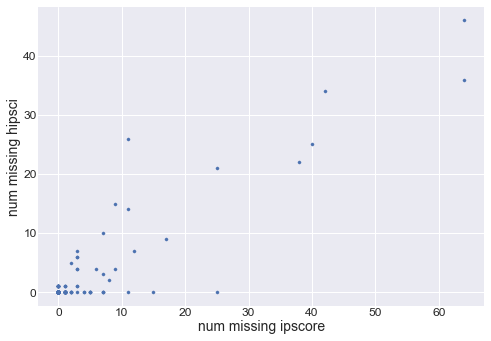

In [87]:
plt.scatter(info.Missing_ipscore, info.Missing_hipsci_fib, s= 10)
plt.xlabel('num missing ipscore')
plt.ylabel('num missing hipsci')

In [4]:
def prep_filter(df):
    df['NAME'] = df.index
    df.index.name = 'index'
    df = df[df.Missing_GTs==False].copy()
    for i in ['MAF_hipsci_fib', 'MAF_ipscore']:
        df[i] = df[i].astype(float)    

    return df 


info2 = info.pipe(prep_filter)

In [13]:
info2[['MAF_ipscore', 'MAF_hipsci_fib']].corr()

,MAF_ipscore,MAF_hipsci_fib
MAF_ipscore,1.000000,0.978076
MAF_hipsci_fib,0.978076,1.000000


Text(0,0.5,u'maf hipsci')

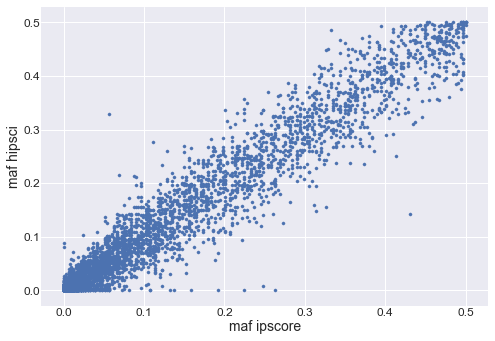

In [65]:
plt.scatter(info2.MAF_ipscore_unrel, info2.MAF_hipsci_fib, s= 10)
plt.xlabel('maf ipscore')
plt.ylabel('maf hipsci')

# Chi Square/Fischer Test for differences in allele dist at each site

In [15]:
import scipy.stats as stats

In [5]:
def prep_filter_chi(df):
    df = df.copy()
    df['NAME'] = df.index
    df.index.name = 'index'
#     df = df[df.NMissing==0].copy()
#     for i in ['MAF_hipsci_fib', 'MAF_ipscore']:
#         df[i] = df[i].astype(float)    

    df = df[(df.NNREF_ipscore_unrel > 0) | (df.NNREF_hipsci_fib > 0)]
    return df 


In [6]:
def prep_melt_info(df):
    df = df.copy()
    df  = df[df.FILTER == 'PASS']
    df.Chr = df['#CHROM'].astype(str)
    return df
    

In [7]:
info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_processing_pipeline/i2QTL_V2/melt_info_annot_full.pkl').pipe(prep_melt_info)

In [8]:
info_chi = info.pipe(prep_filter_chi)

In [9]:
def nz_alleles(dist1, dist2):
    keys = ['0/0', '0/1', '1/1', './.']
    nz1 = [z for z in keys if dist1[z] != 0]
    nz2 = [z for z in keys if dist2[z] != 0]
    
    keys_to_test = list(set(nz1 + nz2))
    return keys_to_test
    


In [10]:
# dropping out ones that have missing
data = []

for i, x in info_chi.iterrows():
    dist_ipscore = x['Alleles_Dist_ipscore_unrel']
    dist_hipsci = x['Alleles_Dist_hipsci_fib']
    site = x['NAME']
    
    keys = nz_alleles(dist_ipscore, dist_hipsci)
    vals_ipscore = [dist_ipscore[z] for z in keys]
    vals_hipsci = [dist_hipsci[z] for z in keys]
    
    try:
        g, p, dof, expctd = stats.chi2_contingency([vals_ipscore, vals_hipsci])
    except:
        print vals_hipsci, vals_ipscore
        break
    data.append(p)
inds = info_chi.NAME.tolist()

    

In [11]:
chiSeries = pd.Series(data, index=inds)

info_chi['chisq_p_allele_dist'] = chiSeries

In [12]:
pval_for_signif = 0.05 / info_chi.shape[0]

In [13]:
tot_for_filt = info_chi[info_chi.chisq_p_allele_dist < pval_for_signif].SVTYPE.value_counts().sum()
"number of sites that deviate significantly from expected between ipscore and hipsci: {}".format(tot_for_filt)

'number of sites that deviate significantly from expected between ipscore and hipsci: 50'

In [14]:
filtered_calls = info_chi[info_chi.chisq_p_allele_dist < pval_for_signif].copy()

In [15]:
info['filter_batch_effect'] = False
info.loc[filtered_calls.index.tolist(), 'filter_batch_effect'] = True

(-0.01, 1)

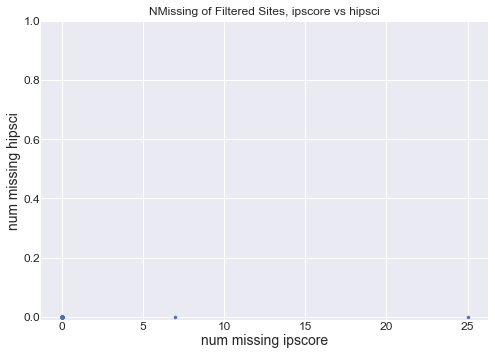

In [85]:
plt.scatter(filtered_calls.Missing_ipscore, filtered_calls.Missing_hipsci_fib, s= 10, clip_on = False)
plt.xlabel('num missing ipscore')
plt.ylabel('num missing hipsci')
plt.title('NMissing of Filtered Sites, ipscore vs hipsci')
plt.ylim(-0.01,1)

In [16]:
def filter_all_missing(df):
    df = df.copy()
    
    cols = ['MAF_ipscore_unrel', 'MAF_hipsci_fib']

    for c in cols:

        try:
            df = df[(df[c] != 'All Missing')]
            df[c] = df[c].astype(float)
        except:
            pass
    
    return df

In [87]:
filtered_nm = filtered_calls.pipe(filter_all_missing)

Text(0.5,1,u'MAF of Filtered Sites, ipscore vs hipsci')

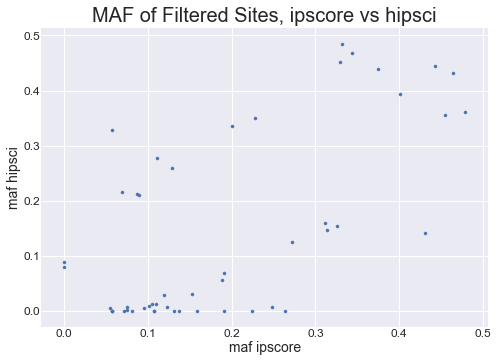

In [88]:
plt.scatter(filtered_nm.MAF_ipscore_unrel, filtered_nm.MAF_hipsci_fib, s= 10)
plt.xlabel('maf ipscore')
plt.ylabel('maf hipsci')
plt.title('MAF of Filtered Sites, ipscore vs hipsci', fontsize = 20)

# Calculate Hardy Weinberg Eq at each site- Chi Sq Test
    1) Using the unrelated iPSCORE individuals 
    2) Using 204 HipSci Fibroblasts (all unrelated)
    3) Using all unrelated samples (iPSCORE + HipSci) 

In [17]:
def hardy_weinberg_expectation(dist1):
    keys = ['0/0', '0/1', '1/1']
    vals1 = [dist1[i] for i in keys]
    tot = sum(vals1)
    
    try:
        p = (2*dist1['0/0'] + dist1['0/1'])/(2*tot)
    except:
        print dist1
        return
    q = 1 - p
    
    exp_AA = (p**2) * tot
    exp_Aa = 2*p*q*tot
    exp_aa = (q**2)*tot
    
    hw_exp = [exp_AA, exp_Aa, exp_aa]
    return vals1, hw_exp

def nz_alleles_list(dist1, dist2):
    keys = ['0/0', '0/1', '1/1', './.']
    nz1 = [z for z in keys if dist1[z] != 0]
    nz2 = [z for z in keys if dist2[z] != 0]
    inds_to_test = list(set(nz1 + nz2))    
    
    return inds_to_test

def get_non_zero_inds(l1, l2):
    nz1 = [i for i,l in list(enumerate(l1)) if l !=0]
    nz2 = [i for i,l in list(enumerate(l2)) if l !=0]
    inds_to_test = list(set(nz1 + nz2))    
    return inds_to_test

def subset_list(l, inds):
    return [l[i] for i in inds]


def get_hwe_chi_comparison_pval(dist):
    
    obs, hwe = hardy_weinberg_expectation(dist)
    inds = get_non_zero_inds(obs, hwe)
    obs_test, hwe_test = (subset_list(obs, inds), subset_list(hwe, inds))
    s = stats.chisquare(obs_test, f_exp=hwe_test)
    p_val = s.pvalue
    
    return p_val

def prep_filter_hwe(df):
    df = df.copy()
    df['NAME'] = df.index
    df.index.name = 'index'
    df = df[df.Missing_GTs==False].copy()
#     for i in ['MAF_hipsci_fib', 'MAF_ipscore']:
#         df[i] = df[i].astype(float)    

    df = df[df.NNREF_i2QTL_unrel > 0]
    # restrict to autosomes
    df = df[~df.Chr.isin(['X', 'Y'])]
#     df = df[df.filter_batch_effect == False]
    return df 

In [18]:
info_hwe = info.pipe(prep_filter_hwe)

In [19]:
data = []
pval_for_signif = 0.05 / info_hwe.shape[0]
for i, x in info_hwe.iterrows():
    dist_ipscore = x['Alleles_Dist_ipscore_unrel']
    dist_hipsci = x['Alleles_Dist_hipsci_fib']
    dist_all = x['Alleles_Dist_i2QTL_unrel']
    
    site = x['NAME']
    keys = nz_alleles(dist_ipscore, dist_hipsci)
    
    p_val_ipscore = get_hwe_chi_comparison_pval(dist_ipscore)
    p_val_hipsci = get_hwe_chi_comparison_pval(dist_hipsci)
    p_val_all = get_hwe_chi_comparison_pval(dist_all)
    
    signif = p_val_all < pval_for_signif
  
    data.append([p_val_ipscore,  p_val_hipsci,  p_val_all, dist_ipscore, dist_hipsci, signif])
    

inds = info_hwe.NAME.tolist()


In [20]:
cols =['hwe_p_ipscore', 'hwe_p_hipsci', 'hwe_p_i2QTL_unrel', 'dist_ipscore', 'dist_hipsci', 'filter_hwe']
hwe = pd.DataFrame(data, index=inds, columns=cols)
info_hwe[cols] = hwe

In [21]:
info_hwe[(info_hwe.ALTAF_i2QTL_unrel > 0.3) & (info_hwe.filter_hwe == True)][cols + ['SVTYPE']].SVTYPE.value_counts()

ALU      221
SVA       23
LINE1     14
Name: SVTYPE, dtype: int64

In [88]:
info_hwe[(info_hwe.ALTAF_i2QTL_unrel > 0.3) & (info_hwe.filter_hwe == True)][cols + ['SVTYPE']].head()

,hwe_p_ipscore,hwe_p_hipsci,hwe_p_i2QTL_unrel,dist_ipscore,dist_hipsci,filter_hwe,SVTYPE
index,,,,,,,
ALU_1_8446635_8446636,1.983358e-12,2.929922e-15,6.020953e-27,"{u'./.': 0, u'0/0': 46, u'1/1': 0, u'0/1': 121}","{u'./.': 0, u'0/0': 53, u'1/1': 1, u'0/1': 150}",True,ALU
ALU_1_58071869_58071870,1.990882e-15,5.390257e-20,1.167591e-34,"{u'./.': 0, u'0/0': 35, u'1/1': 1, u'0/1': 131}","{u'./.': 0, u'0/0': 38, u'1/1': 2, u'0/1': 164}",True,ALU
ALU_1_72639020_72639021,2.237930e-14,2.183765e-15,5.493434e-29,"{u'./.': 0, u'0/0': 40, u'1/1': 0, u'0/1': 127}","{u'./.': 0, u'0/0': 55, u'1/1': 0, u'0/1': 149}",True,ALU
ALU_1_81351537_81351538,7.773977e-05,8.255783e-04,1.291433e-07,"{u'./.': 0, u'0/0': 57, u'1/1': 8, u'0/1': 102}","{u'./.': 0, u'0/0': 92, u'1/1': 6, u'0/1': 106}",True,ALU
ALU_1_85620127_85620128,1.001154e-10,2.056704e-10,2.648094e-20,"{u'./.': 0, u'1/1': 52, u'0/0': 0, u'0/1': 115}","{u'./.': 0, u'1/1': 74, u'0/0': 0, u'0/1': 130}",True,ALU


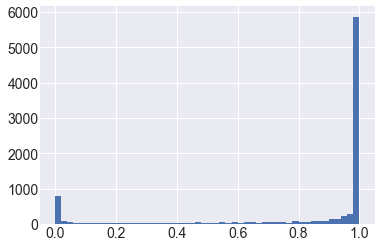

In [57]:
hwe.hwe_p_i2QTL_unrel.hist(bins = 50 )

In [60]:
inds =info_hwe[info_hwe.ALTAF_i2QTL_unrel >0.05].index.tolist()

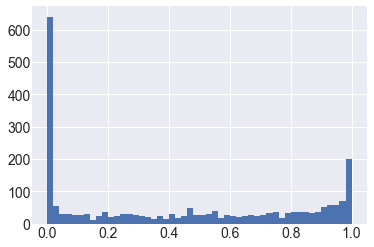

In [61]:
hwe.loc[inds].hwe_p_i2QTL_unrel.hist(bins = 50 )

In [62]:
hwe = hwe.join(info.ALTAF_i2QTL_unrel)

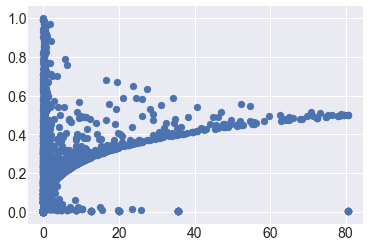

In [67]:
plt.scatter((-1 * np.log10(hwe.hwe_p_i2QTL_unrel)), hwe.ALTAF_i2QTL_unrel)

# P values versus variant type and allele frequency

In [22]:
pval_for_signif = 0.05 / info_hwe.shape[0]

In [69]:
v = info_hwe[info_hwe.hwe_p_i2QTL_unrel < pval_for_signif].SVTYPE.value_counts()

ALU      427
SVA       33
LINE1     32
Name: SVTYPE, dtype: int64

In [100]:
info_hwe[info_hwe.hwe_p_i2QTL_unrel < pval_for_signif].shape

(492, 114)

In [23]:
filtered_hwe = info_hwe[info_hwe.hwe_p_i2QTL_unrel < pval_for_signif].index.tolist()

In [24]:
info['filter_hwe'] = False
info.loc[filtered_hwe, 'filter_hwe'] = True

In [103]:
info_filt = info[(info.filter_hwe==False) & (info.filter_batch_effect == False)] 

In [26]:
CM.save_dataframe('melt_info_filt_qual_batch_hwe', info, private_out)

melt_info_filt_qual_batch_hwe = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_info_filt_qual_batch_hwe.pkl')
melt_info_filt_qual_batch_hwe = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_info_filt_qual_batch_hwe.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/load_pickled_nb_variables.py


# Plot AAF with Filters

In [107]:
def prep_info_color_plot(info):
    # assign colors to different 
    info['color_plot'] = '#00a563'

    batch_hwe = info[(info.filter_hwe == True) & (info.filter_batch_effect == True)].index.tolist()
    batch_only = info[(info.filter_hwe == False) & (info.filter_batch_effect == True)].index.tolist()
    hwe_only = info[(info.filter_hwe == True) & (info.filter_batch_effect == False)].index.tolist()

    info.loc[batch_hwe, 'color_plot'] = '#b73550'
    info.loc[batch_only, 'color_plot'] = '#7c00ff'
    info.loc[hwe_only, 'color_plot'] = '#4286f4'
    return info


In [108]:
def prep_filter_info_plot(df):
    df['NAME'] = df.index
    df.index.name = 'index'
    df = df[df.Chr.isin(CM.normal_Chrs)]
    for i in ['ALTAF_hipsci_fib', 'ALTAF_ipscore']:
        df[i] = df[i].astype(float)    

    return df 

In [109]:
info= pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_info_filt_qual_batch_hwe.pkl')

In [110]:
info = info.pipe(prep_info_color_plot)

In [111]:
info2 = info.pipe(prep_filter)

In [112]:
# pump up sizes on some plotting params

mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 1.5

mpl.rcParams['axes.labelpad'] = 2

mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14

categories = ['HWE', 'Batch', 'HWE,Batch', 'PASS']
colors = ['#4286f4', '#7c00ff', '#b73550', '#00a563']

patches = mpltools.get_legend_patches(categories, markerfacecolor=colors, markersize= 12)

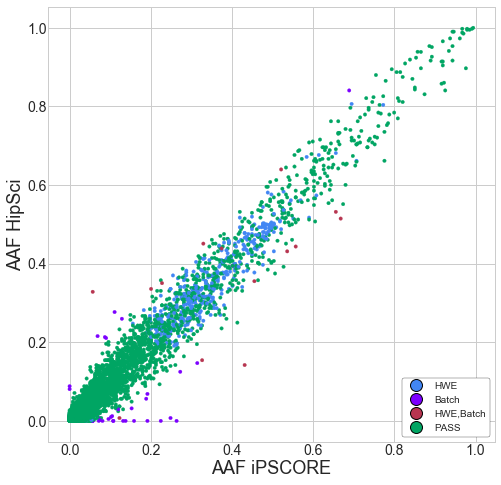

In [113]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    
    ax.scatter(info2.ALTAF_ipscore_unrel, info2.ALTAF_hipsci_fib, c = info2.color_plot, s= 12)
    ax.set_xlabel('AAF iPSCORE')
    ax.set_ylabel('AAF HipSci')
    leg = ax.legend(handles = patches, bbox_to_anchor = (1,0), loc='lower right', frameon=True, framealpha=1, fontsize=10)
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('black')
    

# Make QC Filter Table 

In [108]:
def filter_original(df):
    df = df.copy()
    df['#CHROM'] = df['#CHROM'].astype(str)
    df = df[df['#CHROM'].isin(CM.normal_Chrs)]
    return df

In [109]:
# unfiltered
info_original = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_processing_pipeline/i2QTL_V2/melt_info_annot.pkl').pipe(filter_original)

In [61]:
info_filt= pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_info_qual_batch_hwe.pkl')

In [110]:
tdf1 = info_original.SVTYPE.value_counts().to_frame('no. variants genotyped')

In [111]:
tdf2 = info_original[info_original.FILTER.isin(['ASSESS<5', 'PASS'])].SVTYPE.value_counts().to_frame('no, variants after standard filters')

In [112]:
tdf3 = info_original[info_original.FILTER == 'PASS'].SVTYPE.value_counts().to_frame('no, variants after quality tranche filtering')

In [113]:
tdf4 = info_filt[(info_filt.filter_batch_effect == False) & (info_filt.filter_hwe==False)].SVTYPE.value_counts().to_frame('no, variants after filtering Batch + HWE')

In [116]:
t = pd.concat([tdf1, tdf2, tdf3, tdf4], axis = 1)

In [121]:
totals = t.sum(axis = 0)
t.loc['total'] = totals

In [124]:
CM.save_dataframe('melt_callset_filtering_summary', t, private_out)

melt_callset_filtering_summary = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_callset_filtering_summary.pkl')
melt_callset_filtering_summary = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_callset_filtering_summary.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/load_pickled_nb_variables.py


In [125]:
t

,no. variants genotyped,"no, variants after standard filters","no, variants after quality tranche filtering","no, variants after filtering Batch + HWE"
ALU,70056.0,9298.0,8143.0,7698.0
LINE1,10878.0,1560.0,1251.0,1249.0
SVA,2680.0,769.0,459.0,425.0
total,83614.0,11627.0,9853.0,9372.0
